In [ ]:
import pandas as pd
import numpy as np


# 1. Загрузка данных

In [ ]:
path_train = r"./"

In [ ]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
# параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/y_train.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()

In [ ]:
# характеристики перевозимых грузов
fr_info = pd.read_parquet(path_train + '/freight_info.parquet').convert_dtypes()

In [ ]:
wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')# у вагонов могут меняться параметры, поэтмоу номер дублируется. В данной модели это фактор не учитывается

# 2. Оценка отклонения фактической даты планового ремонта от прогнозной

In [ ]:
# для анализа данных оставляем в таргете только те вагоны, которые фактически ушли в ремонт
target = target[(target.target_month != 0) & (target.target_day != 0)].sort_values(by='wagnum')

In [ ]:
target.describe()

,wagnum,target_month,target_day
count,3336.0,3336.0,3336.0
mean,21184.310552,1.0,1.0
std,9572.914915,0.0,0.0
min,77.0,1.0,1.0
25%,14701.75,1.0,1.0
50%,24688.5,1.0,1.0
75%,28129.0,1.0,1.0
max,33975.0,1.0,1.0


In [ ]:
# для вагонов, по которым есть данные о фактическом уходе в ремонт, формируем датасет, куда будем подтягивать другие данные
wp = target[['wagnum', 'month']]

In [ ]:
# добавим планиремую дату ремонта и посмотрим, насколько она отличается от фактической
wp = wp.merge(dislok[['wagnum', 'date_pl_rem']].drop_duplicates(subset='wagnum', keep='last'), on ='wagnum', how = 'inner')
wp['month'] = pd.to_datetime(wp['month'])
wp['date_pl_rem'] = pd.to_datetime(wp['date_pl_rem'])

In [ ]:
wp['rem_month_diff'] = (pd.DatetimeIndex(wp['date_pl_rem']).year - pd.DatetimeIndex(wp['month']).year) * 12 + pd.DatetimeIndex(wp['date_pl_rem']).month - pd.DatetimeIndex(wp['month']).month

In [ ]:
res1 = wp.rem_month_diff.value_counts().rename_axis('date difference in month').to_frame('count of wagons')
res1

,count of wagons
date difference in month,
0,572
8,296
7,267
6,250
9,237
10,223
5,214
11,188
3,176


In [ ]:
# проверим на конкретных числах: посмотрим на записи для вагонов, которые ушли в ремонт на 19 месяцев раньше прогнозной даты
wp[wp.rem_month_diff == 19]

,wagnum,month,date_pl_rem,rem_month_diff
1125,20926,2022-10-01,2024-05-22,19
2528,28252,2022-11-01,2024-06-10,19


<Axes: xlabel='date difference in month'>

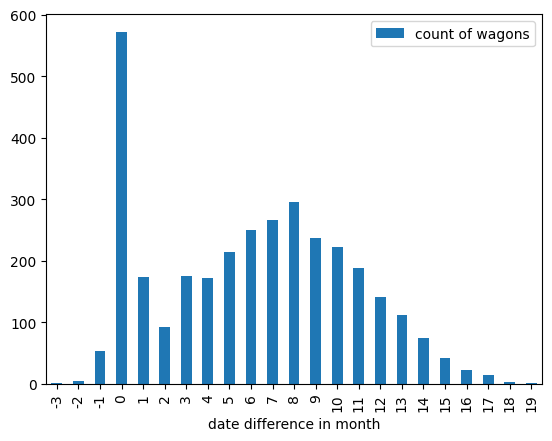

In [ ]:
# построим диаграмму распределения количеств вагонов от отклонения даты ремонта

res1.sort_values(by='date difference in month').plot.bar()

# 3. Оценка влияния характеристик перевозимых грузов на отклонение фактической даты планового ремонта от прогнозной

In [ ]:
# посмотрим, как характеристики груза влияют на ускорение наступления планового ремонта

dislok['date_kap'] = pd.to_datetime(dislok['date_kap'])
dislok['date_dep'] = pd.to_datetime(dislok['date_dep'])
dislok2 = dislok[['wagnum', 'date_kap', 'date_dep', 'fr_id']].merge(fr_info, on='fr_id', how = 'inner')

In [ ]:
# данные по дате последнего ремонта

last_repair = dislok2[['wagnum', 'date_kap', 'date_dep']].drop_duplicates(subset=['wagnum'], keep='last')
last_repair = last_repair.rename(columns={'date_kap': 'last_date_kap', 'date_dep': 'last_date_dep'})

In [ ]:
last_repair

,wagnum,last_date_kap,last_date_dep
247627,11748,2013-05-20,2021-12-04
263552,8816,2011-05-28,2019-09-22
1190393,183,2021-06-28,2019-07-04
1260597,24612,NaT,2019-12-10
1997566,20523,2012-05-19,2021-08-02
...,...,...,...
6095896,8999,2012-11-23,2021-10-25
6095900,29940,NaT,2021-02-08
6095913,25381,2020-04-30,2018-02-12
6095916,1957,NaT,NaT


In [ ]:
dislok2 = dislok2.merge(last_repair, on='wagnum', how = 'inner')

In [ ]:
# оставим только перевозки, которые имели место после последнего ремонта

dislok2 = dislok2[(dislok2.date_kap == dislok2.last_date_kap) & (dislok2.date_dep == dislok2.last_date_dep) | \
                  (pd.isna(dislok2.date_kap) & pd.isna(dislok2.last_date_kap)) & (dislok2.date_dep == dislok2.last_date_dep) | \
                  (pd.isna(dislok2.date_kap) & pd.isna(dislok2.last_date_kap)) & (pd.isna(dislok2.date_dep) & pd.isna(dislok2.last_date_dep))
                  ]

In [ ]:
# агрегируем значения для каждого вагона: из всех классов перевозимых грузов в послеремонтный период оставим моду (наиболее часты классы)
# для специальных характеристик грузов посчитаем количество раз, которые рассматриваемый вагон перевозил их за послеремонтный период

dislok2 = dislok2.groupby(by='wagnum', as_index=False).\
                          agg({'fr_class': lambda x: pd.Series.mode(x)[0], 'skoroport': 'sum', 'naval': 'sum', \
                               'nasip': 'sum', 'naliv': 'sum', 'openvagons': 'sum', 'smerz': 'sum'})

In [ ]:
dislok2.describe()

,wagnum,fr_class,skoroport,naval,nasip,naliv,openvagons,smerz
count,33965.0,33965.0,33965.0,33965.0,33965.0,33965.0,33965.0,33965.0
mean,16989.043044,0.789018,1.703342,67.936994,67.936994,0.756573,7.766524,0.126719
std,9809.333054,0.614906,6.628674,43.97881,43.97881,4.512618,11.253812,1.25214
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,8491.0,0.0,0.0,23.0,23.0,0.0,0.0,0.0
50%,16993.0,1.0,0.0,80.0,80.0,0.0,0.0,0.0
75%,25484.0,1.0,0.0,105.0,105.0,0.0,13.0,0.0
max,33976.0,2.0,88.0,184.0,184.0,84.0,119.0,39.0


Из полученных данных видим, что в послеремонтный период все грузы с особыми характеристиками (насыпные, скоропортящиеся и др.) перевозились, нет характеристики, где бы максимум был равен 0

In [ ]:
# вернемся к нашему датафрейму с данными об отклонении фактической даты ремонта от прогнозируемой
wp.head()

,wagnum,month,date_pl_rem,rem_month_diff
0,77,2022-11-01,2022-11-29,0
1,80,2022-09-01,2022-09-07,0
2,91,2022-10-01,2022-11-21,1
3,92,2022-09-01,2022-10-01,1
4,97,2022-10-01,2022-09-11,-1


In [ ]:
# смержим датафрейм с данными о перевозимых грузах в послеремонтный период
wp2 = wp.merge(dislok2, on='wagnum', how='inner')

In [ ]:
wp2

,wagnum,month,date_pl_rem,rem_month_diff,fr_class,skoroport,naval,nasip,naliv,openvagons,smerz
0,77,2022-11-01,2022-11-29,0,1,0,0,0,0,0,0
1,80,2022-09-01,2022-09-07,0,1,0,24,24,0,0,0
2,91,2022-10-01,2022-11-21,1,1,0,16,16,0,0,0
3,92,2022-09-01,2022-10-01,1,1,54,0,0,54,0,0
4,97,2022-10-01,2022-09-11,-1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3331,33956,2022-11-01,2022-11-06,0,0,0,90,90,0,0,0
3332,33959,2022-10-01,2022-10-20,0,0,0,125,125,0,12,0
3333,33963,2022-10-01,2022-10-25,0,0,0,83,83,0,9,0
3334,33966,2022-10-01,2022-10-24,0,1,0,96,96,0,17,0


Прверим равенство колонок naval и nasip

In [ ]:
wp2['naval'].equals(wp2.nasip)

True

Хоть в теории перевозка груза навалом и насыпью - это 2 разных вида, в данных они идентичны. Поэтому исключим, например, колонку nasip из дальнейшего рассмотрения

In [ ]:
# посмотрим корреляцию

list_features = ['rem_month_diff', 'fr_class',	'skoroport',	'naval',	'naliv',	'openvagons',	'smerz']

wp2.drop('nasip', axis=1, inplace=True)

wp2[list_features].corr()

,rem_month_diff,fr_class,skoroport,naval,naliv,openvagons,smerz
rem_month_diff,1.000000,-0.204103,-0.229494,0.507173,-0.134202,0.286188,0.031737
fr_class,-0.204103,1.000000,0.087554,-0.473532,0.058415,-0.227072,-0.032958
skoroport,-0.229494,0.087554,1.000000,-0.312378,0.638379,-0.167503,-0.024244
naval,0.507173,-0.473532,-0.312378,1.000000,-0.201942,0.443086,0.077426
naliv,-0.134202,0.058415,0.638379,-0.201942,1.000000,-0.104684,-0.015916
openvagons,0.286188,-0.227072,-0.167503,0.443086,-0.104684,1.000000,0.098283
smerz,0.031737,-0.032958,-0.024244,0.077426,-0.015916,0.098283,1.000000


В целом видно, что есть определенная корреляция между первозкой грузов
навалом с отклонением даты ремонта от прогнозной. Рассмотрим эти и другие результаты подробнее по всем характеристикам груза

In [ ]:
# Начнем с класса груза. Посмотрим, грузы каких классов попали в датафрейм, как наиболее часто перевозимые в послеремонтный период

wp2.fr_class.value_counts()

1    1844
0    1186
2     306
Name: fr_class, dtype: Int64

Итого наиболее часто перевозились грузы класса 0, 1 и 2

In [ ]:
# Посмотрим как влияет класс наиболее часто первозимого груза на отклонение фактической даты ремонта от прогнозной

res2_0 = wp2[wp2['fr_class'] == 0].rem_month_diff.value_counts().rename_axis('date difference in month').to_frame('count of wagons (fr_class=0)').\
      sort_values(by='date difference in month')

res2_1 = wp2[wp2['fr_class'] == 1].rem_month_diff.value_counts().rename_axis('date difference in month').to_frame('count of wagons (fr_class=1)').\
      sort_values(by='date difference in month')

res2_2 = wp2[wp2['fr_class'] == 2].rem_month_diff.value_counts().rename_axis('date difference in month').to_frame('count of wagons (fr_class=2)').\
      sort_values(by='date difference in month')


In [ ]:
res2 = res2_0.merge(res2_1, on='date difference in month', how='outer').merge(res2_2, on='date difference in month', how='outer').fillna(0)
res2

,count of wagons (fr_class=0),count of wagons (fr_class=1),count of wagons (fr_class=2)
date difference in month,,,
-1,3.0,46.0,4.0
0,75.0,449.0,48.0
1,28.0,139.0,7.0
2,17.0,64.0,12.0
3,41.0,118.0,17.0
4,65.0,92.0,16.0
5,75.0,122.0,17.0
6,117.0,113.0,20.0
7,114.0,127.0,26.0


Изобразим распределение в виде графиков

<Axes: xlabel='date difference in month'>

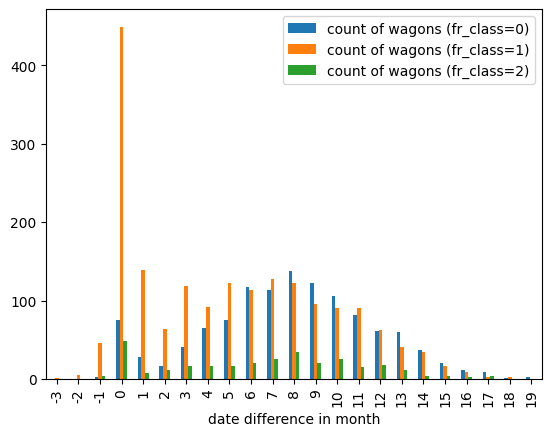

In [ ]:
res2.sort_values(by='date difference in month').plot.bar()

Из представленных результатов видно, что если вагон в основном перевозил грузы класса 1, то в большинстве случаев его прогнозируемая дата ремонта будет соответствовать нормативной. Если же вагон наиболее часто перевозил грузы класса 0 и 2, то в большинстве случаев фактический срок наступления необходимости ремонта будет в среднем на 8 месяцев раньше нормативного

In [ ]:
wp2.describe()

,wagnum,rem_month_diff,fr_class,skoroport,naval,naliv,openvagons,smerz
count,3336.0,3336.000000,3336.0,3336.0,3336.0,3336.0,3336.0,3336.0
mean,21184.310552,6.087230,0.736211,1.01289,77.001499,0.420863,9.654376,0.181355
std,9572.914915,4.496596,0.614631,5.033455,38.325846,3.32692,11.320551,1.441855
min,77.0,-3.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,14701.75,2.000000,0.0,0.0,56.0,0.0,0.0,0.0
50%,24688.5,6.000000,1.0,0.0,88.0,0.0,7.0,0.0
75%,28129.0,9.000000,1.0,0.0,105.0,0.0,15.0,0.0
max,33975.0,19.000000,2.0,62.0,154.0,62.0,119.0,19.0


In [ ]:
wp3_1 = wp2[(wp2.skoroport!=0) ]
wp3_1 = wp3_1[['rem_month_diff', 'skoroport']]
# для каждого варианта отклонения фактической даты ремонта от пргнозной (в месяцах) считаем количество вагонов, которые перевозили
#скоропортящийся груз и медианное значение количеств перевозок такого груза
wp3_1 = wp3_1.groupby(by='rem_month_diff', as_index=False).agg({'skoroport':{'median', 'count'}})

# аналогичные данные группируем для грузов других типов
# для перевозки грузов навалом:
wp3_2 = wp2[(wp2.naval!=0) ]
wp3_2 = wp3_2[['rem_month_diff', 'naval']]
wp3_2 = wp3_2.groupby(by='rem_month_diff', as_index=False).agg({'naval':{'median', 'count'}})

# для перевозки грузов наливом:
wp3_3 = wp2[(wp2.naliv!=0) ]
wp3_3 = wp3_3[['rem_month_diff', 'naliv']]
wp3_3 = wp3_3.groupby(by='rem_month_diff', as_index=False).agg({'naliv':{'median', 'count'}})

# для перевозки грузов открытыми вагонами:
wp3_4 = wp2[(wp2.openvagons!=0) ]
wp3_4 = wp3_4[['rem_month_diff', 'openvagons']]
wp3_4 = wp3_4.groupby(by='rem_month_diff', as_index=False).agg({'openvagons':{'median', 'count'}})

# для перевозки смерзшихся грузов:
wp3_5 = wp2[(wp2.smerz!=0) ]
wp3_5 = wp3_5[['rem_month_diff', 'smerz']]
wp3_5 = wp3_5.groupby(by='rem_month_diff', as_index=False).agg({'smerz':{'median', 'count'}})

# сводим все в единый датафрейм
res3 = wp3_1.merge(wp3_2, on='rem_month_diff', how='outer').merge(wp3_3, on='rem_month_diff', how='outer').\
      merge(wp3_4, on='rem_month_diff', how='outer').merge(wp3_5, on='rem_month_diff', how='outer').fillna(0).sort_values(by='rem_month_diff')
res3.set_index('rem_month_diff', inplace= True)
res3

<ipython-input-31-69b29d051b8b>:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res3 = wp3_1.merge(wp3_2, on='rem_month_diff', how='outer').merge(wp3_3, on='rem_month_diff', how='outer').\
<ipython-input-31-69b29d051b8b>:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res3 = wp3_1.merge(wp3_2, on='rem_month_diff', how='outer').merge(wp3_3, on='rem_month_diff', how='outer').\
<ipython-input-31-69b29d051b8b>:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res3 = wp3_1.merge(wp3_2, on='rem_month_diff', how='outer').merge(wp3_3, on='rem_month_diff', how='outer').\
<ipython-input-31-69b29d051b8b>:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res3 = wp3_1.merge(wp3_2, on='rem_month_diff', how='outer').merge(wp3_3, on='rem_

skoroport         naval        naliv        openvagons         \
                   count median  count median count median      count median   
rem_month_diff                                                                 
-3                   0.0    0.0    1.0   20.0   0.0    0.0        0.0    0.0   
-2                   1.0   46.0    0.0    0.0   0.0    0.0        0.0    0.0   
-1                   5.0   13.0   33.0   31.0   2.0   12.0        8.0    9.0   
 0                  92.0   18.0  452.0   37.0  40.0   15.5      126.0   12.0   
 1                  27.0   21.0  139.0   60.0   7.0   17.0       53.0   13.0   
 2                   8.0   18.5   76.0   79.0   6.0   15.5       42.0   12.5   
 3                  16.0   17.0  156.0   79.0  12.0   15.0       87.0   14.0   
 4                   8.0   17.5  162.0   95.5   5.0   13.0      120.0   14.0   
 5                   2.0   12.0  206.0   92.0   2.0    7.5      153.0   13.0   
 6                   3.0   11.0  247.0   99.0   1.0   47.0      185.0   14.0   
 7                   0.0    0.0  262.0   94.0   0.0    0.0      209.0   13.0   
 8                   1.0   25.0  291.0   99.0   1.0   25.0      231.0   13.0   
 9                   1.0   13.0  236.0   98.0   0.0    0.0      185.0   14.0   
 10                  0.0    0.0  222.0   96.5   0.0    0.0      178.0   13.0   
 11                  0.0    0.0  188.0   94.0   0.0    0.0      149.0   13.0   
 12                  0.0    0.0  142.0   92.0   0.0    0.0      101.0   15.0   
 13                  1.0   11.0  112.0   97.0   0.0    0.0       94.0   12.0   
 14                  0.0    0.0   75.0   93.0   0.0    0.0       65.0   12.0   
 15                  0.0    0.0   42.0   94.0   0.0    0.0       36.0   11.5   
 16                  0.0    0.0   23.0  102.0   0.0    0.0       18.0   17.5   
 17                  0.0    0.0   15.0  102.0   0.0    0.0       13.0   23.0   
 18                  0.0    0.0    3.0   68.0   0.0    0.0        2.0   29.5   
 19                  0.0    0.0    2.0   99.5   0.0    0.0        2.0   17.0   

               smerz         
               count median  
rem_month_diff               
-3               0.0    0.0  
-2               0.0    0.0  
-1               0.0    0.0  
 0               4.0    6.0  
 1               4.0    9.0  
 2               1.0   10.0  
 3               3.0   11.0  
 4               2.0    9.5  
 5               3.0    7.0  
 6               4.0   13.0  
 7              13.0   13.0  
 8               8.0    6.0  
 9               7.0   13.0  
 10              6.0    8.0  
 11              4.0    9.5  
 12              3.0    5.0  
 13              0.0    0.0  
 14              2.0    9.0  
 15              0.0    0.0  
 16              0.0    0.0  
 17              1.0   11.0  
 18              0.0    0.0  
 19              0.0    0.0

Анализ полученных результатов показал следующее:
- перевозка скоропортящегося груза не оказывает существенного влияния на смещение срока ремонта вагонов (для большей части вагонов, в которых имела место перевозка таких грузов, срок фактического ремонта совпадает со прогнозными сроками, либо смещается на месяц)
- перевозка грузов навалом, очевидно, оказывает влияние на сокращение межремонтного периода по сравнению с прогнозными (нормативными) сроками. Из полученных данных следует, что перевозка грузов навалом может иметь незначительное влияние на смещение сроков, если за межремонтный период таких перевозок было 20-40. Если же количество перевозок приближается к 90-100, то срок ремонта может приблизиться в среднем на 9 месяцев по сравнению с прогнозным
- перевозка груза наливом оказывает несущественное влияние на смещение сроков ремонта (в пределах 1-3 месяцев)
- перевозка открытых грузов не оказывает влияния на смещение сроков ремонта (из наблюдаемой равномерности распределения количества вагонов и медианного значения количества перевозов открытых грузов для каждого смещения сроков рассеяние сроков следует, что эти смещения сроков обусловлены иными факторами)
- пеервозка смезшихся грузов по-видимому может привести к смещению сроков ремонта на 6-9 месяцев, но для однозначного вывода мало данных по первозке данных грузов

In [ ]:
res3[res3.index<=8]

skoroport         naval        naliv        openvagons         \
                   count median  count median count median      count median   
rem_month_diff                                                                 
-3                   0.0    0.0    1.0   20.0   0.0    0.0        0.0    0.0   
-2                   1.0   46.0    0.0    0.0   0.0    0.0        0.0    0.0   
-1                   5.0   13.0   33.0   31.0   2.0   12.0        8.0    9.0   
 0                  92.0   18.0  452.0   37.0  40.0   15.5      126.0   12.0   
 1                  27.0   21.0  139.0   60.0   7.0   17.0       53.0   13.0   
 2                   8.0   18.5   76.0   79.0   6.0   15.5       42.0   12.5   
 3                  16.0   17.0  156.0   79.0  12.0   15.0       87.0   14.0   
 4                   8.0   17.5  162.0   95.5   5.0   13.0      120.0   14.0   
 5                   2.0   12.0  206.0   92.0   2.0    7.5      153.0   13.0   
 6                   3.0   11.0  247.0   99.0   1.0   47.0      185.0   14.0   
 7                   0.0    0.0  262.0   94.0   0.0    0.0      209.0   13.0   
 8                   1.0   25.0  291.0   99.0   1.0   25.0      231.0   13.0   

               smerz         
               count median  
rem_month_diff               
-3               0.0    0.0  
-2               0.0    0.0  
-1               0.0    0.0  
 0               4.0    6.0  
 1               4.0    9.0  
 2               1.0   10.0  
 3               3.0   11.0  
 4               2.0    9.5  
 5               3.0    7.0  
 6               4.0   13.0  
 7              13.0   13.0  
 8               8.0    6.0

In [ ]:
res3[res3.index>8]

skoroport         naval        naliv        openvagons         \
                   count median  count median count median      count median   
rem_month_diff                                                                 
9                    1.0   13.0  236.0   98.0   0.0    0.0      185.0   14.0   
10                   0.0    0.0  222.0   96.5   0.0    0.0      178.0   13.0   
11                   0.0    0.0  188.0   94.0   0.0    0.0      149.0   13.0   
12                   0.0    0.0  142.0   92.0   0.0    0.0      101.0   15.0   
13                   1.0   11.0  112.0   97.0   0.0    0.0       94.0   12.0   
14                   0.0    0.0   75.0   93.0   0.0    0.0       65.0   12.0   
15                   0.0    0.0   42.0   94.0   0.0    0.0       36.0   11.5   
16                   0.0    0.0   23.0  102.0   0.0    0.0       18.0   17.5   
17                   0.0    0.0   15.0  102.0   0.0    0.0       13.0   23.0   
18                   0.0    0.0    3.0   68.0   0.0    0.0        2.0   29.5   
19                   0.0    0.0    2.0   99.5   0.0    0.0        2.0   17.0   

               smerz         
               count median  
rem_month_diff               
9                7.0   13.0  
10               6.0    8.0  
11               4.0    9.5  
12               3.0    5.0  
13               0.0    0.0  
14               2.0    9.0  
15               0.0    0.0  
16               0.0    0.0  
17               1.0   11.0  
18               0.0    0.0  
19               0.0    0.0